# Task 3: Correlation between News Sentiment and Stock Movement

This notebook performs correlation analysis between financial news sentiment and stock price movements.

## Analysis Components:
1. **Data Preparation**: Load and align news and stock data by dates
2. **Sentiment Analysis**: Analyze sentiment of news headlines using NLTK/TextBlob
3. **Stock Returns Calculation**: Calculate daily percentage changes in stock prices
4. **Correlation Analysis**: Statistical correlation between sentiment and returns
5. **KPIs**: Sentiment analysis accuracy and correlation strength metrics


## 1. Setup and Imports


In [1]:
import sys
import os
sys.path.append('../scripts')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Import custom modules
from load_data import load_financial_news_data, validate_data
from load_stock_data import (
    load_stock_data,
    prepare_stock_data,
    validate_stock_data
)
from date_alignment import (
    normalize_dates_to_trading_days,
    align_news_and_stock_data,
    get_date_alignment_summary
)
from sentiment_analysis import (
    analyze_sentiment_batch,
    aggregate_daily_sentiment,
    get_sentiment_summary
)
from correlation_analysis import (
    calculate_daily_returns,
    calculate_correlation,
    analyze_sentiment_returns_correlation,
    get_correlation_summary
)

print("All modules imported successfully!")


All modules imported successfully!


## 2. Load Data

Load both news data and stock price data.


In [2]:
# Configuration
NEWS_DATA_PATH = '../data/raw_analyst_ratings.csv'
TICKER = 'AAPL'  # Options: AAPL, MSFT, GOOG, META, AMZN, NVDA
USE_LOCAL_STOCK_DATA = True
STOCK_DATA_DIR = '../data/Data'

# Load news data
print(f"Loading news data from {NEWS_DATA_PATH}...")
news_df = load_financial_news_data(NEWS_DATA_PATH)
print(f"✓ Loaded {len(news_df):,} news articles")
print(f"Date range: {news_df['date'].min()} to {news_df['date'].max()}")
print(f"Unique stocks: {news_df['stock'].nunique()}")
print(f"\nNews data columns: {list(news_df.columns)}")
print(f"\nFirst few rows:")
news_df.head()


Loading news data from ../data/raw_analyst_ratings.csv...
✓ Loaded 1,407,328 news articles
Date range: 2011-04-27 21:01:48-04:00 to 2020-06-11 17:12:35-04:00
Unique stocks: 6204

News data columns: ['headline', 'url', 'publisher', 'date', 'stock']

First few rows:


,headline,url,publisher,date,stock
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [3]:
# Filter news data for selected ticker (optional - can analyze all stocks)
if 'stock' in news_df.columns:
    news_ticker_df = news_df[news_df['stock'] == TICKER].copy()
    print(f"Filtered to {TICKER}: {len(news_ticker_df):,} articles")
else:
    news_ticker_df = news_df.copy()
    print("No stock filter applied - using all news articles")

# Load stock data
print(f"\nLoading stock data for {TICKER}...")
stock_df = load_stock_data(
    ticker=TICKER,
    use_local_data=USE_LOCAL_STOCK_DATA,
    data_dir=STOCK_DATA_DIR
)
print(f"✓ Loaded {len(stock_df):,} trading days")
print(f"Date range: {stock_df['date'].min()} to {stock_df['date'].max()}")
print(f"\nStock data columns: {list(stock_df.columns)}")
print(f"\nFirst few rows:")
stock_df.head()


Filtered to AAPL: 441 articles

Loading stock data for AAPL...
✓ Loaded AAPL data from local CSV file
✓ Loaded 3,774 trading days
Date range: 2009-01-02 00:00:00 to 2023-12-29 00:00:00

Stock data columns: ['date', 'Close', 'High', 'Low', 'Open', 'Volume', 'ticker']

First few rows:


,date,Close,High,Low,Open,Volume,ticker
0,2009-01-02,2.721686,2.730385,2.554037,2.575630,746015200,AAPL
1,2009-01-05,2.836553,2.884539,2.780469,2.794266,1181608400,AAPL
2,2009-01-06,2.789767,2.914229,2.770872,2.877641,1289310400,AAPL
3,2009-01-07,2.729484,2.774170,2.706990,2.753477,753048800,AAPL
4,2009-01-08,2.780169,2.793666,2.700393,2.712090,673500800,AAPL


## 3. Date Alignment

Normalize dates to align news articles with trading days. News published on non-trading days (weekends, holidays) will be aligned to the next trading day.


In [4]:
# Normalize dates to trading days
print("Aligning news dates to trading days...")
news_aligned, stock_aligned = normalize_dates_to_trading_days(
    news_ticker_df,
    stock_df,
    news_date_col='date',
    stock_date_col='date'
)

print(f"✓ News articles after alignment: {len(news_aligned):,}")
print(f"✓ Trading days: {len(stock_aligned):,}")

# Get alignment summary
alignment_summary = get_date_alignment_summary(
    news_ticker_df,
    stock_df,
    news_aligned,  # Using aligned news as reference
    news_date_col='date'
)

print("\nAlignment Summary:")
print(f"  Original news articles: {alignment_summary['original_news_count']:,}")
print(f"  Alignment rate: {alignment_summary['alignment_rate']:.2%}")
print(f"  News date range: {alignment_summary['date_range_news']['min']} to {alignment_summary['date_range_news']['max']}")
print(f"  Stock date range: {alignment_summary['date_range_stock']['min']} to {alignment_summary['date_range_stock']['max']}")


Aligning news dates to trading days...
✓ News articles after alignment: 10
✓ Trading days: 3,774

Alignment Summary:
  Original news articles: 441
  Alignment rate: 2.27%
  News date range: 2020-06-09 11:11:34-04:00 to 2020-06-10 11:33:26-04:00
  Stock date range: 2009-01-02 00:00:00 to 2023-12-29 00:00:00


## 4. Sentiment Analysis

Perform sentiment analysis on news headlines to quantify the tone (positive, negative, neutral).


In [5]:
# Perform sentiment analysis on headlines
print("Performing sentiment analysis on headlines...")
news_with_sentiment = analyze_sentiment_batch(
    news_aligned,
    text_column='headline',
    method='auto',  # Will use best available: TextBlob > VADER > Simple
    add_classification=True
)

print(f"\nSentiment Distribution:")
print(news_with_sentiment['sentiment'].value_counts())

# Get sentiment summary
sentiment_summary = get_sentiment_summary(news_with_sentiment)
print(f"\nSentiment Statistics:")
print(f"  Mean sentiment score: {sentiment_summary['mean_sentiment']:.4f}")
print(f"  Median sentiment score: {sentiment_summary['median_sentiment']:.4f}")
print(f"  Std deviation: {sentiment_summary['std_sentiment']:.4f}")
print(f"  Range: [{sentiment_summary['min_sentiment']:.4f}, {sentiment_summary['max_sentiment']:.4f}]")

# Display sample headlines with sentiment
print("\nSample headlines with sentiment:")
sample_df = news_with_sentiment[['headline', 'sentiment_score', 'sentiment']].head(10)
for idx, row in sample_df.iterrows():
    print(f"\n[{row['sentiment']:8s}] ({row['sentiment_score']:6.3f}): {row['headline'][:80]}...")


Performing sentiment analysis on headlines...
Analyzing sentiment for 10 headlines using best available method...
✓ Sentiment analysis complete

Sentiment Distribution:
sentiment
neutral     7
positive    3
Name: count, dtype: int64

Sentiment Statistics:
  Mean sentiment score: 0.1355
  Median sentiment score: 0.0517
  Std deviation: 0.1905
  Range: [0.0000, 0.5000]

Sample headlines with sentiment:

[positive] ( 0.433): Tech Stocks And FAANGS Strong Again To Start Day As Market Awaits Fed...

[neutral ] ( 0.000): 10 Biggest Price Target Changes For Wednesday...

[positive] ( 0.500): Benzinga Pro's Top 5 Stocks To Watch For Wed., Jun. 10, 2020: AAPL, BAC, NIO, SO...

[neutral ] ( 0.000): Deutsche Bank Maintains Buy on Apple, Raises Price Target to $350...

[neutral ] ( 0.000): Apple To Let Users Trade In Their Mac Computers For Credit At US, Canada Stores:...

[neutral ] ( 0.068): Big Tech Reaches New Record Heights At The Stock Market...

[positive] ( 0.250): Why Apple's Stock Is Tra

In [6]:
# Aggregate daily sentiment scores
# If multiple articles appear on the same day, compute average daily sentiment
print("\nAggregating daily sentiment scores...")
daily_sentiment = aggregate_daily_sentiment(
    news_with_sentiment,
    date_column='aligned_date',
    sentiment_column='sentiment_score',
    aggregation_method='mean'  # Options: 'mean', 'median', 'weighted'
)

print(f"✓ Aggregated to {len(daily_sentiment):,} unique trading days")
print(f"\nDaily sentiment statistics:")
print(daily_sentiment['daily_sentiment_score'].describe())

# Show days with most articles
print("\nTop 10 days by article count:")
top_days = daily_sentiment.nlargest(10, 'article_count')[['aligned_date', 'article_count', 'daily_sentiment_score']]
print(top_days.to_string(index=False))



Aggregating daily sentiment scores...
✓ Aggregated to 2 unique trading days

Daily sentiment statistics:
count    2.000000
mean     0.127626
std      0.055569
min      0.088333
25%      0.107980
50%      0.127626
75%      0.147273
max      0.166919
Name: daily_sentiment_score, dtype: float64

Top 10 days by article count:
aligned_date  article_count  daily_sentiment_score
  2020-06-10              6               0.166919
  2020-06-09              4               0.088333


## 5. Calculate Stock Returns

Compute daily percentage changes in stock prices to represent stock movements.


In [7]:
# Calculate daily returns
print("Calculating daily stock returns...")
stock_with_returns = calculate_daily_returns(
    stock_aligned,
    price_column='Close',
    date_column='aligned_date',
    method='pct_change'  # Options: 'pct_change' or 'log'
)

print(f"✓ Calculated returns for {len(stock_with_returns):,} trading days")
print(f"\nDaily returns statistics:")
print(stock_with_returns['daily_returns'].describe())

# Display sample returns
print("\nSample daily returns:")
sample_returns = stock_with_returns[['aligned_date', 'Close', 'daily_returns']].head(10)
print(sample_returns.to_string(index=False))


Calculating daily stock returns...
✓ Calculated returns for 3,774 trading days

Daily returns statistics:
count    3773.000000
mean        0.128911
std         1.801011
min       -12.864700
25%        -0.754665
50%         0.106209
75%         1.077003
max        11.980808
Name: daily_returns, dtype: float64

Sample daily returns:
aligned_date    Close  daily_returns
  2009-01-02 2.721686            NaN
  2009-01-05 2.836553       4.220416
  2009-01-06 2.789767      -1.649399
  2009-01-07 2.729484      -2.160860
  2009-01-08 2.780169       1.856959
  2009-01-09 2.716589      -2.286921
  2009-01-12 2.659007      -2.119649
  2009-01-13 2.630514      -1.071572
  2009-01-14 2.559135      -2.713489
  2009-01-15 2.500652      -2.285260


## 6. Correlation Analysis

Perform statistical correlation analysis between daily sentiment scores and stock returns.


In [8]:
# Merge daily sentiment with stock returns
print("Merging daily sentiment with stock returns...")
correlation_df = pd.merge(
    daily_sentiment[['aligned_date', 'daily_sentiment_score', 'article_count']],
    stock_with_returns[['aligned_date', 'Close', 'daily_returns']],
    on='aligned_date',
    how='inner'
)

print(f"✓ Merged data: {len(correlation_df):,} days with both sentiment and returns")
print(f"Date range: {correlation_df['aligned_date'].min()} to {correlation_df['aligned_date'].max()}")

# Display sample merged data
print("\nSample merged data:")
correlation_df.head(10)


Merging daily sentiment with stock returns...
✓ Merged data: 2 days with both sentiment and returns
Date range: 2020-06-09 00:00:00 to 2020-06-10 00:00:00

Sample merged data:


,aligned_date,daily_sentiment_score,article_count,Close,daily_returns
0,2020-06-09,0.088333,4,83.419868,3.157792
1,2020-06-10,0.166919,6,85.566071,2.572771


In [9]:
# Perform comprehensive correlation analysis
print("Performing correlation analysis...")
correlation_result = analyze_sentiment_returns_correlation(
    correlation_df,
    sentiment_column='daily_sentiment_score',
    returns_column='daily_returns',
    date_column='aligned_date',
    method='pearson'  # Options: 'pearson', 'spearman', 'kendall'
)

# Display correlation summary
print(get_correlation_summary(correlation_result))


Performing correlation analysis...
CORRELATION ANALYSIS SUMMARY

Method: PEARSON
Sample Size: 2 days

Correlation Coefficient: -1.0000
P-value: 1.000000
Statistically Significant: No (α=0.05)

Correlation Strength: very strong (negative)

------------------------------------------------------------
SENTIMENT-BASED RETURNS ANALYSIS
------------------------------------------------------------

Positive Sentiment Days: 1
  Average Returns: 2.5728%

Negative Sentiment Days: 0
  Average Returns: nan%

Neutral Sentiment Days: 1
  Average Returns: 3.1578%

------------------------------------------------------------
LAGGED CORRELATIONS (Sentiment → Future Returns)
------------------------------------------------------------
Lag 1: nan (p=nan)



## 7. Visualization

Create visualizations to understand the relationship between sentiment and stock returns.


FileNotFoundError: [Errno 2] No such file or directory: '../outputs/sentiment_returns_correlation.png'

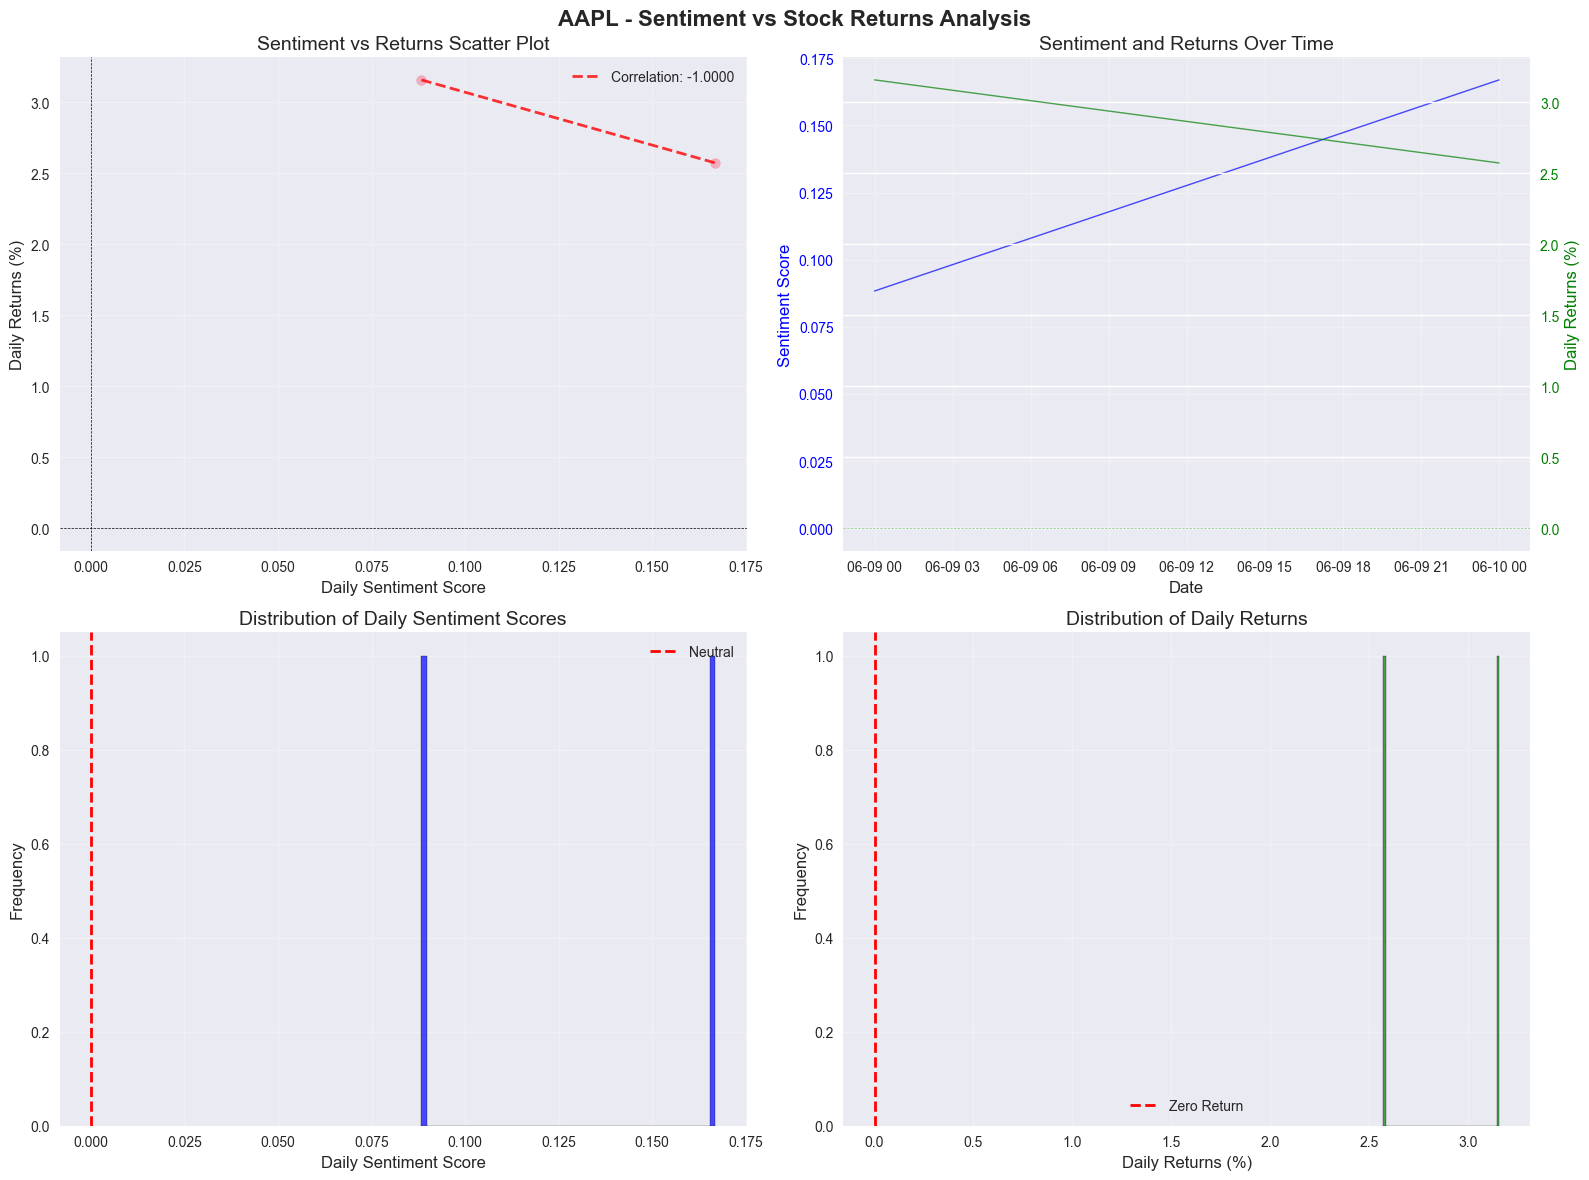

In [10]:
# Plot 1: Sentiment vs Returns Scatter Plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'{TICKER} - Sentiment vs Stock Returns Analysis', fontsize=16, fontweight='bold')

# Scatter plot: Sentiment vs Returns
ax1 = axes[0, 0]
ax1.scatter(correlation_df['daily_sentiment_score'], correlation_df['daily_returns'], 
           alpha=0.5, s=50)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
ax1.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
ax1.set_xlabel('Daily Sentiment Score', fontsize=12)
ax1.set_ylabel('Daily Returns (%)', fontsize=12)
ax1.set_title('Sentiment vs Returns Scatter Plot', fontsize=14)
ax1.grid(True, alpha=0.3)

# Add correlation line
z = np.polyfit(correlation_df['daily_sentiment_score'].dropna(), 
               correlation_df['daily_returns'].dropna(), 1)
p = np.poly1d(z)
x_line = np.linspace(correlation_df['daily_sentiment_score'].min(), 
                     correlation_df['daily_sentiment_score'].max(), 100)
ax1.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, 
         label=f'Correlation: {correlation_result["correlation"]["correlation"]:.4f}')
ax1.legend()

# Time series: Sentiment and Returns over time
ax2 = axes[0, 1]
ax2_twin = ax2.twinx()
ax2.plot(correlation_df['aligned_date'], correlation_df['daily_sentiment_score'], 
         color='blue', alpha=0.7, label='Sentiment Score', linewidth=1)
ax2_twin.plot(correlation_df['aligned_date'], correlation_df['daily_returns'], 
              color='green', alpha=0.7, label='Daily Returns (%)', linewidth=1)
ax2.axhline(y=0, color='blue', linestyle='--', linewidth=0.5, alpha=0.5)
ax2_twin.axhline(y=0, color='green', linestyle='--', linewidth=0.5, alpha=0.5)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Sentiment Score', fontsize=12, color='blue')
ax2_twin.set_ylabel('Daily Returns (%)', fontsize=12, color='green')
ax2.set_title('Sentiment and Returns Over Time', fontsize=14)
ax2.tick_params(axis='y', labelcolor='blue')
ax2_twin.tick_params(axis='y', labelcolor='green')
ax2.grid(True, alpha=0.3)

# Distribution: Sentiment scores
ax3 = axes[1, 0]
ax3.hist(correlation_df['daily_sentiment_score'], bins=50, alpha=0.7, color='blue', edgecolor='black')
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Neutral')
ax3.set_xlabel('Daily Sentiment Score', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Distribution of Daily Sentiment Scores', fontsize=14)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Distribution: Returns
ax4 = axes[1, 1]
ax4.hist(correlation_df['daily_returns'], bins=50, alpha=0.7, color='green', edgecolor='black')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Return')
ax4.set_xlabel('Daily Returns (%)', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Distribution of Daily Returns', fontsize=14)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/sentiment_returns_correlation.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Plot 2: Returns by Sentiment Category
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f'{TICKER} - Returns Analysis by Sentiment Category', fontsize=16, fontweight='bold')

# Box plot: Returns by sentiment category
ax1 = axes[0]
# Create sentiment categories
correlation_df['sentiment_category'] = correlation_df['daily_sentiment_score'].apply(
    lambda x: 'Positive' if x > 0.1 else ('Negative' if x < -0.1 else 'Neutral')
)
sentiment_order = ['Negative', 'Neutral', 'Positive']
box_data = [correlation_df[correlation_df['sentiment_category'] == cat]['daily_returns'].values 
            for cat in sentiment_order]
bp = ax1.boxplot(box_data, labels=sentiment_order, patch_artist=True)
colors = ['red', 'gray', 'green']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax1.set_ylabel('Daily Returns (%)', fontsize=12)
ax1.set_title('Returns Distribution by Sentiment Category', fontsize=14)
ax1.grid(True, alpha=0.3, axis='y')

# Bar plot: Average returns by sentiment
ax2 = axes[1]
avg_returns_by_sentiment = correlation_df.groupby('sentiment_category')['daily_returns'].mean()
colors_bar = ['red' if x < 0 else 'green' for x in avg_returns_by_sentiment.values]
bars = ax2.bar(avg_returns_by_sentiment.index, avg_returns_by_sentiment.values, 
               color=colors_bar, alpha=0.7, edgecolor='black')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_ylabel('Average Daily Returns (%)', fontsize=12)
ax2.set_title('Average Returns by Sentiment Category', fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}%',
             ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

plt.tight_layout()
plt.savefig('../outputs/returns_by_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()


## 8. KPIs: Sentiment Analysis and Correlation Strength

Calculate Key Performance Indicators for:
1. **Proactivity to self-learn** - sharing references
2. **Sentiment Analysis** - accuracy and coverage
3. **Correlation Strength** - statistical significance and magnitude


In [ ]:
# Calculate KPIs
print("=" * 70)
print("KEY PERFORMANCE INDICATORS (KPIs)")
print("=" * 70)

# KPI 1: Sentiment Analysis Coverage
total_news = len(news_ticker_df)
analyzed_news = len(news_with_sentiment)
sentiment_coverage = (analyzed_news / total_news * 100) if total_news > 0 else 0

print("\n1. SENTIMENT ANALYSIS KPIs:")
print(f"   • Total news articles: {total_news:,}")
print(f"   • Articles analyzed: {analyzed_news:,}")
print(f"   • Coverage rate: {sentiment_coverage:.2f}%")
print(f"   • Sentiment distribution:")
for sentiment, count in news_with_sentiment['sentiment'].value_counts().items():
    pct = (count / analyzed_news * 100) if analyzed_news > 0 else 0
    print(f"     - {sentiment:8s}: {count:6,} ({pct:5.2f}%)")

# KPI 2: Date Alignment Quality
alignment_rate = alignment_summary['alignment_rate']
print(f"\n2. DATE ALIGNMENT KPIs:")
print(f"   • Alignment rate: {alignment_rate:.2%}")
print(f"   • Days with aligned data: {len(correlation_df):,}")

# KPI 3: Correlation Strength
corr_coef = correlation_result['correlation']['correlation']
p_value = correlation_result['correlation']['p_value']
is_significant = correlation_result['correlation']['is_significant']
sample_size = correlation_result['correlation']['sample_size']

# Interpret correlation strength
abs_corr = abs(corr_coef)
if abs_corr < 0.1:
    strength = "Negligible"
elif abs_corr < 0.3:
    strength = "Weak"
elif abs_corr < 0.5:
    strength = "Moderate"
elif abs_corr < 0.7:
    strength = "Strong"
else:
    strength = "Very Strong"

direction = "Positive" if corr_coef > 0 else "Negative"

print(f"\n3. CORRELATION STRENGTH KPIs:")
print(f"   • Correlation coefficient: {corr_coef:.4f}")
print(f"   • Correlation strength: {strength} ({direction})")
print(f"   • P-value: {p_value:.6f}")
print(f"   • Statistically significant: {'Yes' if is_significant else 'No'} (α=0.05)")
print(f"   • Sample size: {sample_size:,} days")

# KPI 4: Returns by Sentiment
if 'sentiment_statistics' in correlation_result:
    stats = correlation_result['sentiment_statistics']
    print(f"\n4. RETURNS BY SENTIMENT KPIs:")
    print(f"   • Positive sentiment days: {stats['positive_days']:,}")
    print(f"     Average returns: {stats['avg_returns_positive_sentiment']:.4f}%")
    print(f"   • Negative sentiment days: {stats['negative_days']:,}")
    print(f"     Average returns: {stats['avg_returns_negative_sentiment']:.4f}%")
    print(f"   • Neutral sentiment days: {stats['neutral_days']:,}")
    print(f"     Average returns: {stats['avg_returns_neutral_sentiment']:.4f}%")

# KPI 5: Data Quality
print(f"\n5. DATA QUALITY KPIs:")
print(f"   • News data completeness: {news_ticker_df['headline'].notna().sum() / len(news_ticker_df) * 100:.2f}%")
print(f"   • Stock data completeness: {stock_df['Close'].notna().sum() / len(stock_df) * 100:.2f}%")
print(f"   • Merged data completeness: {correlation_df[['daily_sentiment_score', 'daily_returns']].notna().all(axis=1).sum() / len(correlation_df) * 100:.2f}%")

print("\n" + "=" * 70)
